<a href="https://colab.research.google.com/github/JuneY-Y/ML/blob/main/COMP9418_W04_Markov_Chains_and_Hidden_Markov_Models_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/UNSW-COMP9418/Week04/blob/main/COMP9418_W04_Markov_Chains_and_Hidden_Markov_Models_Solutions.ipynb)

# Markov Chains and Hidden Markov Models

**COMP9418 W04 Tutorial**

- Instructor: Gustavo Batista
- School of Computer Science and Engineering, UNSW Sydney
- Notebook designed by Gustavo Batista and Jeremy Gillen
- Last Update 6th September 2022

In this week's tutorial, we will explore models that utilize Markovian assumptions, specifically Markov chains and Hidden Markov Models. We will implement the forward and Viterbi algorithms and use them to gain insight into the convergence of Markov chains and the probabilistic queries these algorithms can answer.

# Technical prerequisites

You will need certain packages installed to run this notebook.

If you are using ``conda``'s default [full installation](https://conda.io/docs/install/full.html), these requirements should all be satisfied already.

If you are using ``virtualenv`` or other native package management, you may need to run these commands:

```python
pip3 install numpy matplotlib
```

To render a visualization of some graphical models, you also need to install Graphviz [download page](http://www.graphviz.org/download). We have already used this library in the Week 0 Tutorial; thus, you should have it installed. If you do not have it and use the conda installation, then use the command ```conda install python-graphviz```.

Once we have done all that, we import some useful modules for later use.

In [1]:
# Necessary libraries
import numpy as np
import matplotlib.pyplot as plt

from graphviz import Digraph
# combinatorics
from itertools import product, combinations

# library for copying complex objects
import copy

# library for checking if a file exists
import os.path

In [2]:
# Only run this cell if you do not want to use your libraries and
# prefer to download our implementation from GitHub

if not os.path.exists("DiscreteFactors.py"):
    !wget 'https://raw.githubusercontent.com/UNSW-COMP9418/libraries/main/DiscreteFactors.py'
if not os.path.exists("Graph.py"):
    !wget 'https://raw.githubusercontent.com/UNSW-COMP9418/libraries/main/Graph.py'
if not os.path.exists("BayesNet_VE.py"):
    !wget 'https://raw.githubusercontent.com/UNSW-COMP9418/libraries/main/BayesNet_VE.py'

--2025-09-21 00:24:08--  https://raw.githubusercontent.com/UNSW-COMP9418/libraries/main/DiscreteFactors.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7996 (7.8K) [text/plain]
Saving to: ‘DiscreteFactors.py’

DiscreteFactors.py  100%[===================>]   7.81K  --.-KB/s    in 0s      

2025-09-21 00:24:08 (70.3 MB/s) - ‘DiscreteFactors.py’ saved [7996/7996]

--2025-09-21 00:24:08--  https://raw.githubusercontent.com/UNSW-COMP9418/libraries/main/Graph.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8802 (8.6K) [text/plain

In [3]:
from DiscreteFactors import Factor
from Graph import Graph
from BayesNet_VE import BayesNet

# Markov Chains

Let's start implementing the mini-forward algorithm for Markov chains. We will use this algorithm to calculate the probability of a sequence of events and test the convergence of certain chains.

Remember from the course slides that a Markov chain (as well as the Hidden Markov Model) is a Dynamic Bayesian Network (DBN). It means that this network "grows", i.e., we can add nodes as we iterate over time or space. We need to specify a notation to indicate the passage of time. Similarly to the slides, we use $t-1$ and $t$ appended to the variable names to designate the previous time and present time.

We can use the example from the slides to introduce the notation and write the first transition tables.

![](https://raw.githubusercontent.com/UNSW-COMP9418/Week04/main/img/weather.png)

To define a Markov chain, we need to set the outcomeSpace as well as the initial state and the transition probabilities. We will write the first two and leave the third one as an exercise.

In [4]:
# possible outcomes, by variable
outcomeSpace = {
    'Weather':('sun','rain'),
    'Weather_next':('sun','rain'),
}

# The start state, in this case let's assume we start in a sunny day
weatherStart = Factor(('Weather',), outcomeSpace)
weatherStart['sun'] = 1.0
weatherStart['rain'] = 0.0

## Exercise

Now, it is your turn. Define the transition probability table according to the figure above. We have created an initial table for you.

In [6]:
# Answer

weatherTransition = Factor(('Weather', 'Weather_next'), outcomeSpace)
weatherTransition['sun', 'sun'] = 0.9
weatherTransition['sun', 'rain'] = 0.1
weatherTransition['rain', 'sun'] = 0.3
weatherTransition['rain', 'rain'] = 0.7

We can double-check our work with the `graphviz` library. The source code below draws a state transition graph based on the `weatherTransition` table that you just defined. Compare the `graphviz` plot with the slide figure to confirm your state transition probabilities are correct.

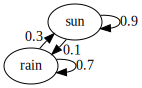

In [7]:
dot = Digraph(engine="neato", comment='Weather Markov chain')
dot.attr(overlap="false", splines="false")

pos = {
    'sun': '1,1!',
    'rain': '0,0!',
}

for v in outcomeSpace['Weather']:
    dot.node(v, pos=pos[v])

for v in outcomeSpace['Weather']:
    for w in outcomeSpace['Weather']:
        dot.edge(v, w, str(weatherTransition[v,w]))

dot

We can now implement the mini-forward algorithm for Markov chains. Remember from the slides that the update rule for the forward simulation is the following:

$P(x_t) = \sum_{x_{t-1}}P(x_t | x_{t-1})P(x_{t-1})$

- $P(x_{t-1})$ is the previous state probability table.

- $P(x_t | x_{t-1})$ is the transition probability table such as the one you defined in the previous exercise.

- $P(x_t)$ is the current state probability table.

From this equation, it is clear that we need two basic operations. One is the multiplication of factors (probability tables) that we implemented in a previous tutorial as a `joint` operation. The second one sums one variable out that we implemented as a `marginalize` operation.

## Exercise

Let's implement the mini-Forward algorithm for Markov chains. We start with the online version that makes a single update (one time step). We use the online version to implement batch one, which runs multiple time steps.

In [8]:
# Answer

class MarkovModel():
    def __init__(self, start_state, transition, variable_remap):
        '''
        Takes 3 arguments:
        - start_state: a factor representing the start state. E.g. domain might be ('A', 'B', 'C')
        - transition: a factor that represents the transition probs. E.g. P('A_next', 'B_next', 'C_next' | 'A', 'B', 'C')
        - variable_remap: a dictionary that maps new variable names to old variable names,
                          to reset the state after transition. E.g. {'A_next':'A', 'B_next':'B', 'C_next':'C'}
        '''
        self.state = start_state
        self.transition = transition
        self.remap = variable_remap

    def forward(self):
        # get state vars (to be marginalized later)
        state_vars = self.state.domain
        # join with transition factor
        f = self.state*self.transition
        # marginalize out old state vars, leaving only new state vars
        for var in state_vars:
            f = f.marginalize(var)
        # remap variables to their original names
        f.domain = tuple(self.remap[var] for var in f.domain)
        self.state = f
        return self.state


##################
# Test code

variable_remap = {
    "Weather_next": "Weather"
}
mm = MarkovModel(weatherStart, weatherTransition, variable_remap)

print(mm.forward())

╒═══════════╤══════╕
│ Weather   │   Pr │
╞═══════════╪══════╡
│ sun       │  0.9 │
├───────────┼──────┤
│ rain      │  0.1 │
╘═══════════╧══════╛



If your implementation is correct, you should have the following output:

```
╒═══════════╤══════╕
│ Weather   │   Pr │
╞═══════════╪══════╡
│ sun       │  0.9 │
├───────────┼──────┤
│ rain      │  0.1 │
╘═══════════╧══════╛
```

We can utilise the mini-forward online implementation to create a simple batch extension that invokes the online subroutine a fixed number of times.

## Exercise

Implement the batch version of the mini-forward algorithm for Markov chains

In [9]:
# Answer

class MarkovModel(MarkovModel):
    def forwardBatch(self, n):
        ''' Do `n` steps, and return history list of states '''
        history = []
        for i in range(n):
            state = self.forward()
            history.append(state)
        return history


##################
# Test code

variable_remap = {
    "Weather_next": "Weather"
}
mm = MarkovModel(weatherStart, weatherTransition, variable_remap)

history = mm.forwardBatch(3)
for factor in history:
    print(factor)

╒═══════════╤══════╕
│ Weather   │   Pr │
╞═══════════╪══════╡
│ sun       │  0.9 │
├───────────┼──────┤
│ rain      │  0.1 │
╘═══════════╧══════╛

╒═══════════╤══════╕
│ Weather   │   Pr │
╞═══════════╪══════╡
│ sun       │ 0.84 │
├───────────┼──────┤
│ rain      │ 0.16 │
╘═══════════╧══════╛

╒═══════════╤═══════╕
│ Weather   │    Pr │
╞═══════════╪═══════╡
│ sun       │ 0.804 │
├───────────┼───────┤
│ rain      │ 0.196 │
╘═══════════╧═══════╛



If you implemented your code correctly, you should see the following output:

```
╒═══════════╤══════╕
│ Weather   │   Pr │
╞═══════════╪══════╡
│ sun       │  0.9 │
├───────────┼──────┤
│ rain      │  0.1 │
╘═══════════╧══════╛

╒═══════════╤══════╕
│ Weather   │   Pr │
╞═══════════╪══════╡
│ sun       │ 0.84 │
├───────────┼──────┤
│ rain      │ 0.16 │
╘═══════════╧══════╛

╒═══════════╤═══════╕
│ Weather   │    Pr │
╞═══════════╪═══════╡
│ sun       │ 0.804 │
├───────────┼───────┤
│ rain      │ 0.196 │
╘═══════════╧═══════╛

```

We will now test the convergence of some Markov chains. Remember from the lectures that chains were classified according to two properties:

1. Reducibility. An irreducible (or regular) chain has the property that every state is reachable from every state. Therefore, the chain has a single stationary distribution. A reducible chain does not have this property and, therefore, can have multiple stationary distributions. The general idea is that, if a chain has, say, two disconnected sets of states **A** and **B**, and we start in a state $a \in \textbf{A}$, then we will never reach a state in **B**. In this case, the stationary distribution will depend on the transition probabilities of the states in **A**. The same occurs if we start in a state $b \in \textbf{B}$.

2. Periodicity. An irreducible chain is not guaranteed to converge. To ensure convergence, we need an additional property: aperiodicity. An aperiodic chain avoids alternating forever between states without ever settling in a stationary distribution. A practical issue in that, although irreducible aperiodic chains are guaranteed to converge to a single stationary distribution, the convergence can be very slow, depending on the transition probabilities.

## Exercise

Let's implement an additional method, `forwardUntilConvergence`, that runs until convergence or a maximum number of iterations. We will establish convergence when the error between two consecutive state probability distributions is smaller than a threshold.

Let's start with the implementation of `forwardUntilConvergence`. We implemented a helper function `factorError` that computes the absolute error between two factors. The error can be thought of as a measure of distance between two factors.

╒═══════════╤══════════╕
│ Weather   │       Pr │
╞═══════════╪══════════╡
│ sun       │ 0.750001 │
├───────────┼──────────┤
│ rain      │ 0.249999 │
╘═══════════╧══════════╛



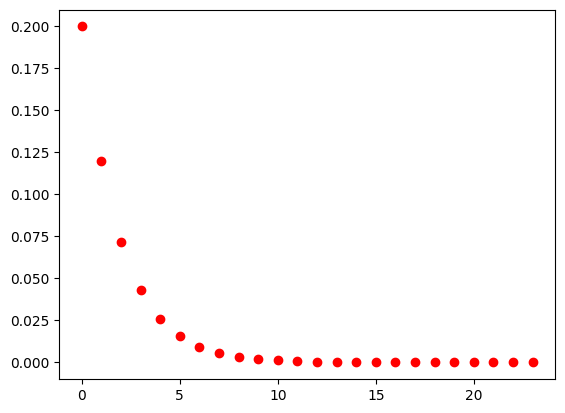

In [10]:
# Answer

def factorError(f1, f2):
    """
    argument
    `f1`, factor with the current state probability distribution in the chain.
    `f2`, factor with the previous state probability distribution in the chain.

    Returns absolute error between f1 and f2.
    """
    assert f1.domain == f2.domain
    return np.sum(np.abs(f1.table - f2.table))

class MarkovModel(MarkovModel):
    def forwardUntilConvergence(self, max_iters=1000, eps=0.000001):
        '''
        Arguments:
        `n`, maximum number of time updates.
        `eps`, error threshold to determine convergence.
        Returns:
        A history of error values
        A factor that represents the current state of the chain after n time steps or the convergence error is less than eps.
        '''
        errors = []
        prevState = self.state
        for i in range(max_iters):
            newState = self.forward()
            error = factorError(prevState, newState)
            if error < eps:
                break
            errors.append(error)
            prevState = newState
        return errors, newState

##################
# Test code

variable_remap = {
    "Weather_next": "Weather"
}
mm = MarkovModel(weatherStart, weatherTransition, variable_remap)
errors, state = mm.forwardUntilConvergence()
print(state)
plt.plot(errors, 'ro')
plt.show()

If you implemented your code correctly, you should see an output like this:

```
╒═══════════╤══════════╕
│ Weather   │       Pr │
╞═══════════╪══════════╡
│ sun       │ 0.750001 │
├───────────┼──────────┤
│ rain      │ 0.249999 │
╘═══════════╧══════════╛
```

## Exercise

Now, we can test the convergence of some Markov chains from the previous tutorial.

The first one has the following transition matrix:

$\begin{bmatrix}
0 & 1 & 0 & 0 \\
1/2 & 0 & 1/2 & 0 \\
0 & 1/2 & 0 & 1/2 \\
0 & 0 & 1 & 0 \\
\end{bmatrix}$
    
This chain is irreducible since we can reach any state from any state. However, it is periodic since if we start from state 1 in time 1, we reach states 1 and 3 at odd times and 2 and 4 at even times. Its stationary distribution is $(1/6, 2/6, 2/6, 1/6)$.

Use the implemented function to confirm that this chain does not converge. Use the next cell to define the necessary variables and call the `forwardUntilConvergence` function.

╒═════╤══════════╕
│   R │       Pr │
╞═════╪══════════╡
│   0 │ 0.333333 │
├─────┼──────────┤
│   1 │ 0        │
├─────┼──────────┤
│   2 │ 0.666667 │
├─────┼──────────┤
│   3 │ 0        │
╘═════╧══════════╛



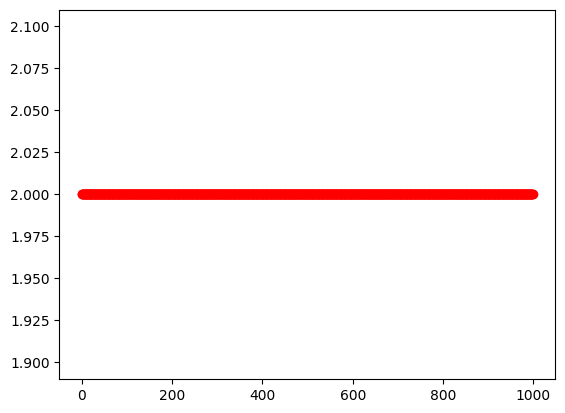

In [11]:
# Answer

outcomeSpace_c1 = {
    'R':(0,1,2,3),
    'R_next':(0,1,2,3),
}

t = Factor(('R', 'R_next'), outcomeSpace_c1)
t[0, 0] = 0.0
t[0, 1] = 1.0
t[0, 2] = 0.0
t[0, 3] = 0.0
t[1, 0] = 0.5
t[1, 1] = 0.0
t[1, 2] = 0.5
t[1, 3] = 0.0
t[2, 0] = 0.0
t[2, 1] = 0.5
t[2, 2] = 0.0
t[2, 3] = 0.5
t[3, 0] = 0.0
t[3, 1] = 0.0
t[3, 2] = 1.0
t[3, 3] = 0.0

s = Factor(('R',), outcomeSpace_c1)
s[0] = 1.0
s[1] = 0.0
s[2] = 0.0
s[3] = 0.0


##################
# Test code

variable_remap = {
    "R_next": "R"
}
mm = MarkovModel(s, t, variable_remap)
errors, state = mm.forwardUntilConvergence()
print(state)
plt.plot(errors, 'ro')
plt.show()

The second one has the following transition matrix:

$\begin{bmatrix}
1/2 & 1/2 & 0 & 0 \\
1/2 & 0 & 1/2 & 0 \\
0 & 1/2 & 0 & 1/2 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}$
    
This chain is reducible since state 4 is absorbing (once entered, cannot be left) and aperiodic. Its stationary distribution is $(0, 0, 0, 1)$.

Use the implemented function to verify the convergence of this chain. Use the next cell to define the necessary variables and call the `forwardUntilConvergence` function.

╒═════╤═════════════╕
│   R │          Pr │
╞═════╪═════════════╡
│   0 │ 1.99564e-06 │
├─────┼─────────────┤
│   1 │ 1.60038e-06 │
├─────┼─────────────┤
│   2 │ 8.88141e-07 │
├─────┼─────────────┤
│   3 │ 0.999996    │
╘═════╧═════════════╛



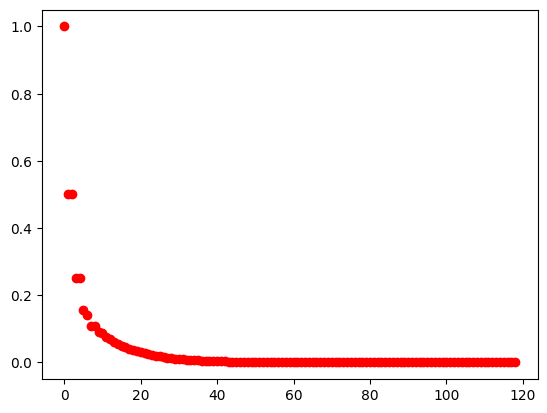

In [12]:
# Answer

outcomeSpace_c2 = {
    'R':(0,1,2,3),
    'R_next':(0,1,2,3),
}

t = Factor(('R', 'R_next'), outcomeSpace_c2)
# We can set the values in the factor in a different way by directly setting the table
# This is quicker, but you have to be careful that the domain is in the right order
t.table = np.array(
    [
     [.5, .5, 0, 0],
     [.5, 0, .5, 0],
     [0, .5, 0, .5],
     [0, 0, 0, 1]
    ]
)

s = Factor(('R',), outcomeSpace_c2)
s.table = np.array(
    [1,0,0,0]
)

##################
# Test code

variable_remap = {
    "R_next": "R"
}
mm = MarkovModel(s, t, variable_remap)
errors, state = mm.forwardUntilConvergence()
print(state)
plt.plot(errors, 'ro')
plt.show()

The third one has the following transition matrix:

$\begin{bmatrix}
1/2 & 1/2 & 0 & 0 \\
1/2 & 1/2 & 0 & 0 \\
0 & 0 & 1/2 & 1/2 \\
0 & 0 & 1/2 & 1/2 \\
\end{bmatrix}$
    
This chain is reducible since we cannot reach states {3,4} from states {1,2} and vice versa, and it is aperiodic. It has two stationary distributions: $(1/2, 1/2, 0, 0)$ and $(0, 0, 1/2, 1/2)$.

Use the implemented function to verify the convergence of this chain. Use the next cell to define the necessary variables and call the `forwardUntilConvergence` function.

╒═════╤══════╕
│   R │   Pr │
╞═════╪══════╡
│   0 │  0.5 │
├─────┼──────┤
│   1 │  0.5 │
├─────┼──────┤
│   2 │  0   │
├─────┼──────┤
│   3 │  0   │
╘═════╧══════╛



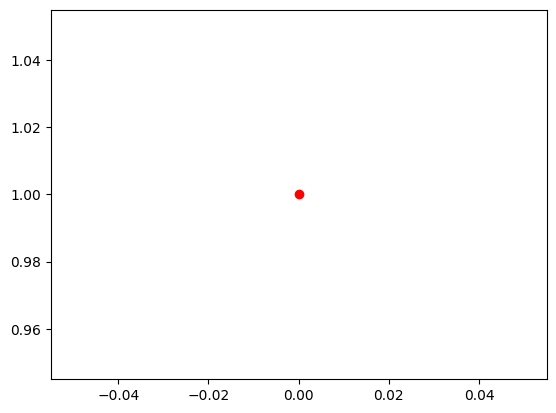

In [13]:
# Answer

outcomeSpace_c3 = {
    'R':(0,1,2,3),
    'R_next':(0,1,2,3),
}

t = Factor(('R', 'R_next'), outcomeSpace_c3)
t.table = np.array(
    [[.5, .5, 0, 0],
     [.5, .5, 0, 0],
     [0, 0, .5, .5],
     [0, 0, .5, .5]]
)

s = Factor(('R',), outcomeSpace_c3)
s.table = np.array(
    [1,0,0,0]
)

##################
# Test code

variable_remap = {
    "R_next": "R"
}
mm = MarkovModel(s, t, variable_remap)
errors, state = mm.forwardUntilConvergence()
print(state)
plt.plot(errors, 'ro')
plt.show()

Finally, we have a chain in the form:

$\begin{bmatrix}
1-e & e \\
e & 1-e \\
\end{bmatrix}$
    
This chain is irreducible and aperiodic, but its convergence can be very slow for small values of $e$. It has one stationary distribution: $(1/2, 1/2)$.

Use the implemented function to verify the convergence of the chain. Change the value of $e$. Use the next cell to define the necessary variables and call the `forwardUntilConvergence` function.

╒═════╤═══════════╕
│   R │        Pr │
╞═════╪═══════════╡
│   0 │ 0.909357  │
├─────┼───────────┤
│   1 │ 0.0906428 │
╘═════╧═══════════╛



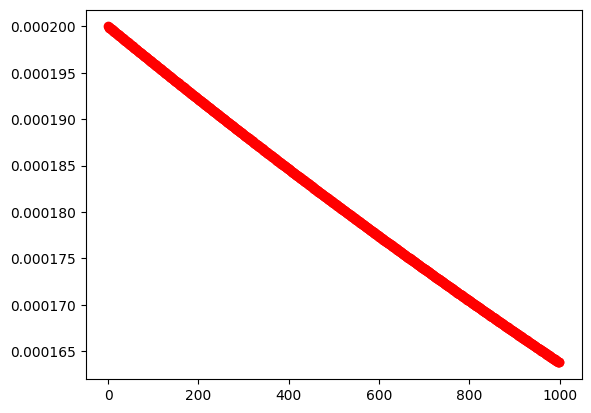

In [14]:
# Answer

e = 0.0001

outcomeSpace_c4 = {
    'R':(0,1),
    'R_next':(0,1),
}

t = Factor(('R', 'R_next'), outcomeSpace_c4)
t.table = np.array(
    [[1-e, e],
     [e, 1-e]]
)

s = Factor(('R',), outcomeSpace_c4)
s.table = np.array(
    [1,0]
)

##################
# Test code

variable_remap = {
    "R_next": "R"
}
mm = MarkovModel(s, t, variable_remap)
errors, state = mm.forwardUntilConvergence()
print(state)
plt.plot(errors, 'ro')
plt.show()


# PageRank algorithm

The PageRank algorithm is the original algorithm used by Google's 1.0 version. It can be interpreted as a direct application of Markov chains.

PageRank models the web as a state graph, where pages are states and hyperlinks represent transitions. The transition probabilities are set as follows:

Imagine you are surfing the web.
* With 85% probability, you will jump to the following website by randomly selecting from the links on that page.
* With 15% probability, you will jump randomly to any random page on the graph.
* If you are on a page with no links, you will always jump to a random page on the graph.

Using these transition probabilities, the PageRank algorithm estimates the stationary distribution over webpages and uses the probabilities of this distribution as an estimate of the "popularity" of every webpage.

The following figure from [Wikipedia](https://en.wikipedia.org/wiki/PageRank) illustrates the final probabilities (in percentages) of PageRank for a small graph.

![](https://raw.githubusercontent.com/UNSW-COMP9418/Week04/main/img/page_rank.png)

Let's use the mini-forward algorithm to implement the PageRank algorithm. We will use this figure to check our results. We start by defining this graph. We will do it for you.

In [16]:
# alpha sets the weight portion reserved for regular edges
alpha = .85

outcomePageRank = {
    "P":('A','B','C','D','E','F','G','H','I','J','K'),
    "P_next":('A','B','C','D','E','F','G','H','I','J','K'),
}

page_graph = Graph({
    "A" : [],
    'B' : ['C'],
    'C' : ['B'],
    'D' : ['B','A'],
    'E' : ['B','D','F'],
    'F' : ['B','E'],
    'G' : ['B','E'],
    'H' : ['B','E'],
    'I' : ['B','E'],
    'J' : ['E'],
    'K' : ['E'],
})

## Exercise

Fill in the function below to create a transition table according to the rules above.

In [ ]:
def createTransitionTable(graph, outcomePageRank, alpha=0.85):
    N = len(graph)
    phantomTransition = Factor(('P', 'P_next'), outcomePageRank)

    # for every pair of nodes in the graph
    for u in outcomePageRank['P']:
        for v in outcomePageRank['P_next']:
            # find the number of outgoing links
            out_degree = len(graph.children(u))
            if out_degree == 0:
                # starting at a node 'u' with no neighbors, what's the probability of jumping to v?
                prob_v_given_u = ... # TODO
            else:
                if v in graph.children(u):
                    # starting at 'u', the probability of jumping to a connected node 'v'.
                    # (Make sure you take into account the 15% possibility of randomly jumping to any node)
                    prob_v_given_u = ... # TODO
                else:
                    # starting at 'u', the probability of jumping to a random node 'v'
                    prob_v_given_u = ... # TODO
            phantomTransition[u,v] = prob_v_given_u
    return phantomTransition

pageRankTransition = createTransitionTable(page_graph, outcomePageRank)
print(pageRankTransition)

In [ ]:
# Answer

def createTransitionTable(graph, outcomePageRank, alpha=0.85):
    N = len(graph)
    phantomTransition = Factor(('P', 'P_next'), outcomePageRank)

    # for every pair of nodes in the graph
    for u in outcomePageRank['P']:
        for v in outcomePageRank['P_next']:
            # find the number of outgoing links
            out_degree = len(graph.children(u))
            if out_degree == 0:
                # starting at a node 'u' with no neighbors, what's the probability of jumping to v?
                prob_v_given_u = 1/N
            else:
                if v in graph.children(u):
                    # starting at 'u', the probability of jumping to a connected node 'v'.
                    # (Make sure you take into account the 15% possibility of randomly jumping to any node)
                    prob_v_given_u = alpha/out_degree + (1-alpha)/N
                else:
                    # starting at 'u', the probability of jumping to a random node 'v'
                    prob_v_given_u = (1-alpha)/N
            phantomTransition[u,v] = prob_v_given_u
    return phantomTransition

pageRankTransition = createTransitionTable(page_graph, outcomePageRank)
print(pageRankTransition)

Let's use ``GraphViz`` again to plot this graph and ensure we have designed it correctly. Note that we will not print all $11^2$ conditional probabilities, only the ones that correspond to following a link in the above graph. For a node with one outgoing edge, that edge should have a probability of $0.85 + 0.15\times(1/11) \approx 0.864$, which is the sum of the probability of following the link $85$% and the probability of randomly choosing the connected node $15\%\times(1/11)$.

In [ ]:
dot = Digraph(engine="neato", comment='PageRank Markov chain')
dot.attr(overlap="false", splines="false", strict="true")

pos = {
    'A': '0,2!',
    'B': '2,2!',
    'C': '4,2!',
    'D': '0,1!',
    'E': '3,1!',
    'F': '4,1!',
    'G': '0,0!',
    'H': '1,0!',
    'I': '2,0!',
    'J': '3,0!',
    'K': '4,0!',
}

for v in page_graph:
    dot.node(v, pos=pos[v])

for v in page_graph:
    for w in page_graph.children(v):
        dot.edge(v, w, str(round(pageRankTransition[v,w],3)))

dot

## Running PageRank

In [ ]:
variable_remap = {
    "P_next": "P"
}

# We set all states with equal initial probabilities
startPageRank = Factor(('P',), outcomePageRank)
startPageRank['A'] = 1/11
startPageRank['B'] = 1/11
startPageRank['C'] = 1/11
startPageRank['D'] = 1/11
startPageRank['E'] = 1/11
startPageRank['F'] = 1/11
startPageRank['G'] = 1/11
startPageRank['H'] = 1/11
startPageRank['I'] = 1/11
startPageRank['J'] = 1/11
startPageRank['K'] = 1/11

pageRankTransition = createTransitionTable(page_graph, outcomePageRank)

mm = MarkovModel(startPageRank, pageRankTransition, variable_remap)
errors, page_rank = mm.forwardUntilConvergence()
print(page_rank)
plt.plot(errors, 'ro')
plt.show()

We can use ``GraphViz`` to visualise the results of the PageRank algorithm implementation. The next cell tries to mimic the Wikipedia figure.

In [ ]:
dot = Digraph(engine="neato", comment='PageRank Markov chain')
dot.attr(overlap="false", splines="false", strict="true")

pos = {
    'A': '0,2!',
    'B': '2,2!',
    'C': '4,2!',
    'D': '0,1!',
    'E': '3,1!',
    'F': '4,1!',
    'G': '0,0!',
    'H': '1,0!',
    'I': '2,0!',
    'J': '3,0!',
    'K': '4,0!',
}

for v in page_graph:
    dot.node(v, pos=pos[v], label=v+'\n'+str(round(page_rank[v]*100,1)))

for v in page_graph:
    for w in page_graph.children(v):
        dot.edge(v, w)

dot

![](https://raw.githubusercontent.com/UNSW-COMP9418/Week04/main/img/page_rank.png)

# Hidden Markov Models (HMMs)

We now turn our attention to Hidden Markov Models (HMMs). These are popular dynamic Bayesian Networks. We will implement the forward and Viterbi algorithms and verify how these algorithms provide answers to the questions on the theory part of this tutorial.

We start with the forward algorithm. According to the lecture slides, the forward algorithm for HMMs has the following form:

1. The transition step is similar to Markov chains. In this step, time passes, and the distribution moves towards its stationary distribution.

    $P(x_t|e_{1:t-1}) = \sum_{x_{t-1}}P(x_{t-1}|e_{1:t-1})P(x_t|x_{t-1})$

    where, $P(x_t|e_{1:t-1})$ is the current state before observing the evidence $e_t$. $P(x_{t-1}|e_{1:t-1})$ is the previous state and $P(x_t|x_{t-1})$ is the transition probability.


2. The emission step has the following form:

    $P(x_t|e_{1:t}) \propto P(x_t|e_{1:t-1})P(e_t|x_t)$

    where, $P(x_t|e_{1:t-1})$ is the current state after observing the evidence $e_t$. $P(x_t|e_{1:t-1})$ is the current state before observing the evidence (obtained in the previous step), and $P(e_t|x_t)$ is the emission probability.


The symbol $\propto$ means that the emission step requires a normalization. The normalization is necessary because we are omitting the denominator in the emission update. The denominator is the probability of the evidence, which we frequently do not have readily available. Although we can compute such a quantity, the normalization is usually easier to calculate.

## Exercise

Let's implement the forward algorithm for Hidden Markov Models (HMMs).

To make this function more flexible, we will allow the user to pass an empty emission value as a placeholder. This means that no evidence was observed in this step. Also, the renormalization will be optional, so we will keep it commented for now.

In [ ]:
class HiddenMarkovModel():
    def __init__(self, start_state, transition, emission, variable_remap):
        '''
        Takes 3 arguments:
        - start_state: a factor representing the start state. E.g. domain might be ('A', 'B', 'C')
        - transition: a factor that represents the transition probs. E.g. P('A_next', 'B_next', 'C_next' | 'A', 'B', 'C')
        - emission: emission probabilities. E.g. P('O' | 'A', 'B', 'C')
        - variable_remap: a dictionary that maps new variable names to old variable names,
                            to reset the state after transition. E.g. {'A_next':'A', 'B_next':'B', 'C_next':'C'}
        '''
        self.state = start_state
        self.transition = transition
        self.emission = emission
        self.remap = variable_remap

        # These lists will be used later to find the mostly likely sequence of states
        self.history = []
        self.prev_history = []

    def forward(self, **emission_evi):
        # get state vars (to be marginalized later)
        state_vars = self.state.domain

        # join with transition factor
        f = ... # TODO

        # marginalize out old state vars, leaving only new state vars
        for var in state_vars:
            f = ... # TODO

        # remap variables to their original names
        f.domain = tuple(self.remap[var] for var in f.domain)
        self.state = f

        # set emission evidence
        emissionFactor = ... # TODO

        # join with state factor
        f = ... # TODO

        # marginalize out emission vars
        for var in f.domain:
            if var not in state_vars:
                f = ... # TODO
        self.state = f

        # normalize state (keep commented out for now)
        # self.state = self.state.normalize()

        return self.state

In [ ]:
# Answer

class HiddenMarkovModel():
    def __init__(self, start_state, transition, emission, variable_remap):
        '''
        Takes 3 arguments:
        - start_state: a factor representing the start state. E.g. domain might be ('A', 'B', 'C')
        - transition: a factor that represents the transition probs. E.g. P('A_next', 'B_next', 'C_next' | 'A', 'B', 'C')
        - emission: emission probabilities. E.g. P('O' | 'A', 'B', 'C')
        - variable_remap: a dictionary that maps new variable names to old variable names,
                            to reset the state after transition. E.g. {'A_next':'A', 'B_next':'B', 'C_next':'C'}
        '''
        self.state = start_state
        self.transition = transition
        self.emission = emission
        self.remap = variable_remap

        self.history = []
        self.prev_history = []

    def forward(self, **emission_evi):
        # get state vars (to be marginalized later)
        state_vars = self.state.domain

        # join with transition factor
        f = self.state*self.transition

        # marginalize out old state vars, leaving only new state vars
        for var in state_vars:
            f = f.marginalize(var)

        # remap variables to their original names
        f.domain = tuple(self.remap[var] for var in f.domain)
        self.state = f

        # set emission evidence
        emissionFactor = self.emission.evidence(**emission_evi)

        # join with state factor
        f = self.state*emissionFactor

        # marginalize out emission vars
        for var in f.domain:
            if var not in state_vars:
                f = f.marginalize(var)
        self.state = f

        # normalize state (keep commented out for now)
        # self.state = self.state.normalize()

        return self.state

Let's use the weather example from the lecture to test our implementation. In this example, a graduate student attempts to determine the current weather state by observing his advisor carrying an umbrella.

These are the transition and emission probabilities:

In [ ]:
##################
# Test code

# possible outcomes, by variable
outcomeSpace = {
    'Weather':('sun','rain'),
    'Weather_next':('sun','rain'),
    'Umbrella': ('umbrella', 'no_umbrella'),
}

weatherStart = Factor(('Weather',), outcomeSpace)
weatherStart['sun'] = 0.5
weatherStart['rain'] = 0.5
weatherTransition = Factor(('Weather', 'Weather_next'), outcomeSpace)
weatherTransition['sun', 'sun'] = 0.7
weatherTransition['sun', 'rain'] = 0.3
weatherTransition['rain', 'sun'] = 0.3
weatherTransition['rain', 'rain'] = 0.7
weatherEmission = Factor(('Weather', 'Umbrella'), outcomeSpace)
weatherEmission['sun', 'umbrella'] = 0.2
weatherEmission['sun', 'no_umbrella'] = 0.8
weatherEmission['rain', 'umbrella'] = 0.9
weatherEmission['rain', 'no_umbrella'] = 0.1

variable_remap = {
    'Weather_next': 'Weather'
}

hmm = HiddenMarkovModel(weatherStart, weatherTransition, weatherEmission, variable_remap)
print(hmm.forward(Umbrella='umbrella'))

hmm = HiddenMarkovModel(weatherStart, weatherTransition, weatherEmission, variable_remap)
print(hmm.forward())

If you implemented your code correctly, you should see an output like this:

```
╒═══════════╤══════╕
│ Weather   │   Pr │
╞═══════════╪══════╡
│ sun       │ 0.1  │
├───────────┼──────┤
│ rain      │ 0.45 │
╘═══════════╧══════╛

╒═══════════╤══════╕
│ Weather   │   Pr │
╞═══════════╪══════╡
│ sun       │  0.5 │
├───────────┼──────┤
│ rain      │  0.5 │
╘═══════════╧══════╛
```

## Exercise

Let's now implement the batch version of the forward algorithm. The batch version takes as input a sequence of `n` observations and outputs an array of length `n` with the state distribution at each time step.

We have created a stub for you. You should pass as an argument a list of evidence observations. Call the online version of the algorithm as many times as you have items in the emissionEviList.

In [ ]:
class HiddenMarkovModel(HiddenMarkovModel):
    def forwardBatch(self, n, **emission_evi):
        '''
        emission_evi: A dictionary of lists, each list containing the evidence list for a variable.
                         Use `None` if no evidence for that timestep
        '''
        history = []
        for i in range(n):
            # select evidence for this timestep
            evi_dict = dict([(key, value[i]) for key, value in emission_evi.items() if value[i] is not None])

            # take a step forward
            state = ... # TODO
            history.append(state)
        return history

In [ ]:
# Answer

class HiddenMarkovModel(HiddenMarkovModel):
    def forwardBatch(self, n, **emission_evi):
        '''
        emission_evi: A dictionary of lists, each list containing the evidence list for a variable.
                         Use `None` if no evidence for that timestep
        '''
        history = []
        for i in range(n):
            # select evidence for this timestep
            evi_dict = dict([(key, value[i]) for key, value in emission_evi.items() if value[i] is not None])

            # take a step forward
            state = self.forward(**evi_dict)
            history.append(state)
        return history

In [ ]:
hmm = HiddenMarkovModel(weatherStart, weatherTransition, weatherEmission, variable_remap)
timeLine = hmm.forwardBatch(2, Umbrella=['umbrella', 'umbrella'])
for t in range(len(timeLine)):
    print("Time: ", t)
    print(timeLine[t])
    print()

If your implementation is correct. You should see an output like this one:

```
Time:  0
╒═══════════╤══════╕
│ Weather   │   Pr │
╞═══════════╪══════╡
│ sun       │ 0.1  │
├───────────┼──────┤
│ rain      │ 0.45 │
╘═══════════╧══════╛


Time:  1
╒═══════════╤════════╕
│ Weather   │     Pr │
╞═══════════╪════════╡
│ sun       │ 0.041  │
├───────────┼────────┤
│ rain      │ 0.3105 │
╘═══════════╧════════╛

```

Now, let's implement the Viterbi algorithm. The Viterbi algorithm provides answers to queries in the form of the most likely explanation (MLE). In other words, the output will be the most likely instantiation for each of the hidden states.

According to the course slides, the Viterbi algorithm has the following equations:

$m_t[x_t] = P(e_t|x_t) max_{x_{t-1}}P(x_t|x_{t-1})m_{t-1}[x_{t-1}]$

where,

- $m_t[x_t]$ is the MLE for time $t$.
- $P(e_t|x_t)$ is the emission probability.
- $P(x_t|x_{t-1})$ is the transition probability.
- $m_{t-1}[x_{t-1}]$ is the MLE for time $t-1$.

## Exercise

To implement the Viterbi algorithm, we will need an intermediate operation, `maximize`. Such an operation is similar to `marginalize` in the sense that it will eliminate one variable of a factor. However, instead of summing out this variable, we will compute the maximum among the entries.

We have created a stub for you. You will need to complete a few gaps.

In [ ]:
class Factor(Factor):
    def maximize(self, var, return_prev=False):
        '''
        Usage: f.maximize('B'), where 'B' is a variable name.
        This function removes a variable from the domain, and maximizes over that variable in the table
        The return_prev argument will be used when tracing back the viterbi algorithm
        '''

        # create new domain
        ... # TODO

        # remove an axis of the table by taking a maximum over that axis
        axis = self.domain.index(var)
        new_table = ... # TODO

        # create a new factor to be returned
        outputFactor = self.__class__(tuple(new_dom),self.outcomeSpace, new_table)

        if return_prev:
            # get the index chosen when taking maximum (to be used later in the viterbi algorithm)
            prev = np.argmax(self.table, axis=axis)
            return outputFactor, prev
        else:
            return outputFactor


################
# Test code

# re-initialize the factors so that it has access to the maximize function
weatherStart = Factor(weatherStart.domain, weatherStart.outcomeSpace, weatherStart.table)
weatherTransition = Factor(weatherTransition.domain, weatherTransition.outcomeSpace, weatherTransition.table)
weatherEmission = Factor(weatherEmission.domain, weatherEmission.outcomeSpace, weatherEmission.table)

print(weatherEmission.maximize('Umbrella'))

In [ ]:
# Answer

class Factor(Factor):
    def maximize(self, var, return_prev=False):
        '''
        Usage: f.maximize('B'), where 'B' is a variable name.
        This function removes a variable from the domain, and maximizes over that variable in the table
        '''

        # create new domain
        new_dom = list(self.domain)
        new_dom.remove(var)

        # remove an axis of the table by summing it out
        axis = self.domain.index(var)
        new_table = np.max(self.table, axis=axis)

        outputFactor = self.__class__(tuple(new_dom),self.outcomeSpace, new_table)

        if return_prev:
            prev = np.argmax(self.table, axis=axis)
            return outputFactor, prev
        else:
            return outputFactor


################
# Test code

# re-initialize the factors so that it has access to the maximize function
weatherStart = Factor(weatherStart.domain, weatherStart.outcomeSpace, weatherStart.table)
weatherTransition = Factor(weatherTransition.domain, weatherTransition.outcomeSpace, weatherTransition.table)
weatherEmission = Factor(weatherEmission.domain, weatherEmission.outcomeSpace, weatherEmission.table)

print(weatherEmission.maximize('Umbrella'))

If your implementation is correct, you should see the following output:

```
╒═══════════╤══════╕
│ Weather   │   Pr │
╞═══════════╪══════╡
│ sun       │  0.8 │
├───────────┼──────┤
│ rain      │  0.9 │
╘═══════════╧══════╛
```

## Exercise

We are now in a position to implement the Viterbi algorithm. We have started the implementation and left a few details for you to fill in. As before, we will code the online version first. The online version provides the output for a single time and an evidence observation increment. The batch version is a simple extension of the online algorithm.

In [ ]:
class HiddenMarkovModel(HiddenMarkovModel):
    def viterbi(self, **emission_evi):
        '''
        This function is very similar to the forward algorithm.
        For simplicity, we will assume that there is only one state variable, and one emission variable.
        '''

        # confirm that state and emission each have 1 variable
        assert len(self.state.domain) == 1
        assert len(self.emission.domain) == 2
        assert len(self.transition.domain) == 2

        # get state and evidence var names (to be marginalized and maximised out later)
        state_var_name = self.state.domain[0]
        emission_vars = [v for v in self.emission.domain if v not in self.state.domain]
        emission_var_name = emission_vars[0]

        # join with transition factor
        f = ... # TODO

        # maximize out old state vars, leaving only new state vars
        f, prev = ... # TODO (use return_prev to also return prev)
        self.prev_history.append(prev) # save prev for use in traceback

        # remap variables to their original names
        f.domain = tuple(self.remap[var] for var in f.domain)
        self.state = f

        # set emission evidence
        emissionFactor = ... # TODO

        # join with state factor
        f = ... # TODO

        # marginalize out emission vars
        f = ... # TODO
        self.state = f

        # normalize state (keep commented out for now)
        # self.state = self.state.normalize()

        self.history.append(self.state)

        return self.state

    def viterbiBatch(self, n,  **emission_evi):
        '''
        emission_evi: A dictionary of lists, each list containing the evidence list for a variable.
                         Use `None` if no evidence for that timestep
        '''
        for i in range(n):
            # get evidence for this timestep
            evi_dict = dict([(key, value[i]) for key, value in emission_evi.items() if value[i] is not None])
            ... # TODO take a step using the `viterbi` method
        return self.history

##################
# Test code

hmm = HiddenMarkovModel(weatherStart, weatherTransition, weatherEmission, variable_remap)
print(hmm.viterbi(Umbrella='umbrella'))


In [ ]:
# Answer

class HiddenMarkovModel(HiddenMarkovModel):
    def viterbi(self, **emission_evi):
        '''
        This function is very similar to the forward algorithm.
        For simplicity, we will assume that there is only one state variable, and one emission variable.
        '''

        # confirm that state and emission each have 1 variable
        assert len(self.state.domain) == 1
        assert len(self.emission.domain) == 2
        assert len(self.transition.domain) == 2

        # get state and evidence var names (to be marginalized and maximised out later)
        state_var_name = self.state.domain[0]
        emission_vars = [v for v in self.emission.domain if v not in self.state.domain]
        emission_var_name = emission_vars[0]

        # join with transition factor
        f = self.state*self.transition

        # maximize out old state vars, leaving only new state vars
        f, prev = f.maximize(state_var_name, return_prev=True)
        self.prev_history.append(prev)

        # remap variables to their original names
        f.domain = tuple(self.remap[var] for var in f.domain)
        self.state = f

        # set emission evidence
        emissionFactor = self.emission.evidence(**emission_evi)

        # join with state factor
        f = self.state*emissionFactor

        # marginalize out emission var if it is in the factor domain
        if emission_var_name in f.domain:
            f = f.marginalize(emission_var_name)

        # normalize state (keep commented out for now)
        # self.state = self.state.normalize()

        self.state = f
        self.history.append(self.state)
        return self.state

    def viterbiBatch(self, n,  **emission_evi):
        '''
        emission_evi: A dictionary of lists, each list containing the evidence list for a variable.
                         Use `None` if no evidence for that timestep
        '''
        for i in range(n):
            # select evidence for this timestep
            evi_dict = dict([(key, value[i]) for key, value in emission_evi.items() if value[i] is not None])
            self.viterbi(**evi_dict)
        return self.history

##################
# Test code

hmm = HiddenMarkovModel(weatherStart, weatherTransition, weatherEmission, variable_remap)
print(hmm.viterbi(Umbrella='umbrella'))

If your implementation is correct, you should see the following output:

```
╒═══════════╤═══════╕
│ Weather   │    Pr │
╞═══════════╪═══════╡
│ sun       │ 0.07  │
├───────────┼───────┤
│ rain      │ 0.315 │
╘═══════════╧═══════╛
```

Now, we can test the batch version of the Viterbi algorithm with a simple code that runs 2 iterations and prints the timeline.

In [ ]:
hmm = HiddenMarkovModel(weatherStart, weatherTransition, weatherEmission, variable_remap)
timeLine = hmm.viterbiBatch(2, Umbrella=['umbrella', 'umbrella'])
for t in range(len(timeLine)):
    print("Time: ", t)
    print(timeLine[t])

If your implementation is correct, you should see the following output:

```
Time:  0
╒═══════════╤═══════╕
│ Weather   │    Pr │
╞═══════════╪═══════╡
│ sun       │ 0.07  │
├───────────┼───────┤
│ rain      │ 0.315 │
╘═══════════╧═══════╛

Time:  1
╒═══════════╤═════════╕
│ Weather   │      Pr │
╞═══════════╪═════════╡
│ sun       │ 0.0189  │
├───────────┼─────────┤
│ rain      │ 0.19845 │
╘═══════════╧═════════╛
```

Before we conclude with an exercise, here are some suggestions for ways to improve the source code of this tutorial:

1. The forward algorithm typically does not normalize the intermediate results. You can make this step optional with a flag. This change can also be done to the Viterbi algorithm.

2. If you do not normalize, the probabilities will assume small values due to the sequence of multiplications. In this case, operating with log-probabilities will decrease the chance of having underflows.

3. For simplicity, we are assuming the update steps are composed of a transition followed by an emission. But it is not always the case. It would be better if these steps could be inverted or, even better, implemented independently of each other.

# Finding the MPE Assignment

As we discussed in the lecture, the MPE assignment can be found in the output computed by the Viterbi algorithm. Remember that the correct assignment is obtained when we trace back the computations, starting with the last state and working our way towards the first state. There are two main approaches for finding the MPE assignment:

1. Use an additional data structure to store pointers indicating the path of the highest probability.

2. Use the output of the Viterbi algorithm and trace back the computations.

In the next cell, we provide a function to find the MPE assignment using the output of the ``viterbi`` function. We will use the first method of finding the MPE assignment.

In [ ]:
class HiddenMarkovModel(HiddenMarkovModel):
    def traceBack(self):
        '''
        This function iterates backwards over the history to find the most
        likely sequence of states.
        For simplicity, this function assumes there is one state variable
        '''
        # get most likely outcome of final state
        index = np.argmax(self.history[-1].table)

        # Go through "prev_history" in reverse
        indexList = []
        for prev in reversed(self.prev_history):
            indexList.append(index)
            index = prev[index]
        indexList = reversed(indexList)

        # translate the indicies into the outcomes they represent
        mleList = []
        stateVar = self.state.domain[0]
        for idx in indexList:
            mleList.append(self.state.outcomeSpace[stateVar][idx])
        return mleList

####################
## Test code

hmm = HiddenMarkovModel(weatherStart, weatherTransition, weatherEmission, variable_remap)
timeLine = hmm.viterbiBatch(2, Umbrella=['umbrella', 'umbrella'])
mpe = hmm.traceBack()
print(mpe)

## Exercise

You can use the implemented code to find the numerical answers to the questions of the theory part of this tutorial.

### Question 1

Lisa is given a fair coin $C_1$ and asked to flip it eight times in a row. Lisa also has a biased coin $C_2$ with a 0.8 probability of landing heads. All we know is that Lisa initially flipped the fair coin, but we believe she intends to switch to the biased coin and tends to be 10% successful in performing the switch. Suppose we observe the outcome of the eight coin flips and want to determine whether Lisa managed to perform a coin switch and when. What is the solution to this problem, assuming that the flips came out as follows:

    a. tails, tails, tails, heads, heads, heads, heads, heads
    b. tails, tails, heads, heads, heads, heads, heads, heads

In [ ]:
# Answer

outcomeSpaceLisa = {
    "C":('fair','biased'),
    "C_next":('fair','biased'),
    "U":('heads', 'tails')
}

t = Factor(('C', 'C_next'), outcomeSpaceLisa)
t['fair', 'fair'] = 0.9
t['fair', 'biased'] = 0.1
t['biased', 'fair'] = 0.0
t['biased', 'biased'] = 1.0

s = Factor(('C',), outcomeSpaceLisa)
s['fair'] = 1.0
s['biased'] = 0.0

e = Factor(('C', 'U'), outcomeSpaceLisa)
e['fair', 'heads'] = 0.5
e['fair', 'tails'] = 0.5
e['biased', 'heads'] = 0.8
e['biased', 'tails'] = 0.2


####################
## Test code

variable_remap = {'C_next': 'C'}
hmm = HiddenMarkovModel(s, t, e, variable_remap)
timeLine = hmm.viterbiBatch(8, U=('tails', 'tails', 'tails', 'heads', 'heads', 'heads', 'heads', 'heads'))
mpe = hmm.traceBack()
print(mpe)
for factor in timeLine:
    print(factor)

variable_remap = {'C_next': 'C'}
hmm = HiddenMarkovModel(s, t, e, variable_remap)
timeLine = hmm.viterbiBatch(8, U=('tails', 'tails', 'heads', 'heads', 'heads', 'heads', 'heads', 'heads'))
mpe = hmm.traceBack()
print(mpe)
for factor in timeLine:
    print(factor)

### Question 2

Consider a cow that may be infected with a disease that can be detected by performing a milk test. The test is performed over five consecutive days, resulting in five outcomes. We aim to determine the state of the cow's infection over the past few days, based on the test outcomes. The prior probability of an infection on day one is 1/10,000; the test's false positive rate is 5/1,000; and its false negative rate is 1/1,000. Moreover, the state of infection on a given day depends only on its state on the previous day. In particular, the probability of a new infection on a given day is 2/10,000, while the probability that an infection would persist to the next day is 7/10.

What is the most likely state of the cow's infection over the five days, given the following test outcomes:

    a. positive, positive, negative, positive, positive
    b. positive, negative, negative, positive, positive
    c. positive, negative, negative, negative, positive

In [ ]:
# Answer

outcomeSpaceCow = {
    "Cow_next":('healthy','infected'),
    "Cow":('healthy','infected'),
    "Test": ('positive', 'negative')
}

transitionCow = Factor(('Cow', 'Cow_next'), outcomeSpaceCow)
transitionCow['healthy', 'healthy'] = 0.9998
transitionCow['healthy', 'infected'] = 0.0002
transitionCow['infected', 'healthy'] = 0.3
transitionCow['infected', 'infected'] = 0.7

startCow = Factor(('Cow',), outcomeSpaceCow)
startCow['healthy'] = 0.9999
startCow['infected'] = 0.0001

evidenceCow = Factor(('Cow', 'Test'), outcomeSpaceCow)
evidenceCow['healthy', 'positive'] = 0.005
evidenceCow['healthy', 'negative'] = 0.995
evidenceCow['infected', 'positive'] = 0.999
evidenceCow['infected', 'negative'] = 0.001

variable_remap = {'Cow_next': 'Cow'}
hmm = HiddenMarkovModel(startCow, transitionCow, evidenceCow, variable_remap)
timeLine = hmm.viterbiBatch(5, Test=('positive', 'positive', 'negative', 'positive', 'positive'))
mpe = hmm.traceBack()
print(mpe)

hmm = HiddenMarkovModel(startCow, transitionCow, evidenceCow, variable_remap)
timeLine = hmm.viterbiBatch(5, Test=('positive', 'negative', 'negative', 'positive', 'positive'))
mpe = hmm.traceBack()
print(mpe)

hmm = HiddenMarkovModel(startCow, transitionCow, evidenceCow, variable_remap)
timeLine = hmm.viterbiBatch(5, Test=('positive', 'negative', 'negative', 'negative', 'positive'))
mpe = hmm.traceBack()
print(mpe)

# Final Task
Add the `maximize` method to your DiscreteFactors.py file

In [ ]:
from itertools import product
from tabulate import tabulate
import copy
import numpy as np

class Factor:
    '''
    Factors are a generalisation of discrete probability distributions over one or more random variables.
    Each variable must have a name (which may be a string or integer).
    The domain of the factor specifies which variables the factor operates over.
    The outcomeSpace specifies the possible outcomes of each variable.


    The probabilities are stored in a n-dimensional numpy array, using the domain and outcomeSpace
    as dimension and row labels respectively.
    '''
    def __init__(self, domain, outcomeSpace, table=None, trivial=False):
        '''
        Inititalise a factor with a given domain and outcomeSpace.
        All probabilities are set to uniform distribution by default.
        If trivial=True then it creates a trivial factor (all entries equal to one).
        '''
        self.domain = tuple(domain) # tuple of variable names, which may be strings, integers, etc.

        if table is None:
            # By default, intitialize with a uniform distribution
            self.table = np.ones(shape=tuple(len(outcomeSpace[var]) for var in self.domain))
            if not trivial:
                self.table = self.table/np.sum(self.table)
        else:
            self.table = table

        self.outcomeSpace = copy.copy(outcomeSpace)

    def __getitem__(self, outcomes):
        '''
        Usage: f['sunny','true'], where 'sunny' and 'true' are outcomes.

        This function allows direct access to individual probabilities.
        E.g. if the factor represents a joint distribution over variables 'A','B','C','D', each with outcomeSpace [0,1,2],
        then `factor[0,1,0,2]` will return the probability that the four variables are set to 0,1,0,2 respectively.

        The outcomes used for indexing may also be strings. If in the example above the outcomeSpace of each variable is
        ['true','false'], then `factor['true','false','true','true']` will return the probability that
        A='true', B='false', C='true' and D='true'.

        The order of the indicies is determined by the order of the variables in self.domain.
        '''

        # check if only a single index was used.
        if not isinstance(outcomes, tuple):
            outcomes = (outcomes,)

        # convert outcomes into array indicies
        indicies = tuple(self.outcomeSpace[var].index(outcomes[i]) for i, var in enumerate(self.domain))
        return self.table[indicies]

    def __setitem__(self, outcomes, new_value):
        '''
        This function is called when setting a probability. E.g. `factor[0,1,0,2] = 0.5`.
        '''
        if not isinstance(outcomes, tuple):
            outcomes = (outcomes,)
        indicies = tuple(self.outcomeSpace[var].index(outcomes[i]) for i, var in enumerate(self.domain))
        self.table[indicies] = new_value

    def join(self, other):
        '''
        Usage: `new = f.join(g)` where f and g are Factors
        This function multiplies two factors.
        '''
        # confirm that any shared variables have the same outcomeSpace
        for var in set(other.domain).intersection(set(self.domain)):
            if self.outcomeSpace[var] != other.outcomeSpace[var]:
                print(var,other.domain, other.outcomeSpace[var], other.table)
                print(self, other)
                raise IndexError('Incompatible outcomeSpaces. Make sure you set the same evidence on all factors')

        # extend current domain with any new variables required
        new_dom = list(self.domain) + list(set(other.domain) - set(self.domain))

        # to prepare for multiplying arrays, we need to make sure both arrays have the correct number of axes
        self_t = self.table
        other_t = other.table
        for _ in set(other.domain) - set(self.domain):
            self_t = self_t[..., np.newaxis]
        for _ in set(self.domain) - set(other.domain):
            other_t = other_t[..., np.newaxis]

        # And we need the new axes to be transposed to the correct location
        old_order = list(other.domain) + list(set(self.domain) - set(other.domain))
        new_order = []
        for v in new_dom:
            new_order.append(old_order.index(v))
        other_t = np.transpose(other_t, new_order)

        # Now that the arrays are all set up, we can rely on numpy broadcasting to work out which numbers need to be multiplied.
        # https://numpy.org/doc/stable/user/basics.broadcasting.html
        new_table = self_t * other_t

        # The final step is to create the new outcomeSpace
        new_outcomeSpace = self.outcomeSpace.copy()
        new_outcomeSpace.update(other.outcomeSpace)

        # in the following line, `self.__class__` is the same as `Factor` (except it doesn't break things when subclassing)
        return self.__class__(tuple(new_dom), new_outcomeSpace, table=new_table)

    def evidence(self, **kwargs):
        '''
        Usage:  f.evidence(A='true', B='sunny'), where 'A' and 'B' are variable
                names, and 'true' and 'sunny' are the observed outcomes.

        Sets evidence by modifying the outcomeSpace
        This function must be used to set evidence on all factors before joining,
        because it removes the relevant variable from the factor.

        Usage: fac.evidence(A='true',B='false')
        This returns a factor which has set the variable 'A' to 'true' and 'B' to 'false'.
        '''
        f = self.copy()
        evidence_dict = kwargs
        for var, value in evidence_dict.items():
            if var in f.domain:

                # find the row index that corresponds to var = value
                index = f.outcomeSpace[var].index(value)

                # find the `var` axis and select only the row that corresponds to `value`
                # on all other axes, select every row
                slice_tuple = tuple(slice(index,index+1) if v == var else slice(None) for v in f.domain)
                f.table = f.table[slice_tuple]

                # modify the outcomeSpace to correspond to the changes just made to self.table
                f.outcomeSpace[var] = (value,)
        return f

    def evidence2(self, **kwargs):
        '''
        Usage:  f.evidence(A='true', B='sunny'), where 'A' and 'B' are variable
                names, and 'true' and 'sunny' are the observed outcomes.

        Sets evidence by modifying the outcomeSpace
        This function must be used to set evidence on all factors before joining,
        because it removes the relevant variable from the factor.

        Usage: fac.evidence(A='true',B='false')
        This returns a factor which has set the variable 'A' to 'true' and 'B' to 'false'.
        '''
        f = self.copy()
        evi = kwargs
        indicies = tuple(self.outcomeSpace[v].index(evi[v]) if v in evi else slice(None) for v in self.domain)
        f.table = f.table[indicies]
        f.domain = tuple(v for v in f.domain if v not in evi)
        return f

    def marginalize(self, var):
        '''
        Usage: f.marginalize('B'), where 'B' is a variable name.
        This function removes a variable from the domain, and sums over that variable in the table
        '''

        if var in self.domain:
            # create new domain
            new_dom = list(self.domain)
            new_dom.remove(var)

            # remove an axis of the table by summing it out
            axis = self.domain.index(var)
            new_table = np.sum(self.table, axis=axis)

            # in the following line, `self.__class__` is the same as `Factor` (except it doesn't break things when subclassing)
            return self.__class__(tuple(new_dom),self.outcomeSpace, new_table)
        else:
            return self


    def maximize(self, var, return_prev=False):
        '''
        Usage: f.maximize('B'), where 'B' is a variable name.
        This function removes a variable from the domain, and maximizes over that variable in the table
        '''

        # create new domain
        new_dom = list(self.domain)
        new_dom.remove(var)

        # remove an axis of the table by summing it out
        axis = self.domain.index(var)
        new_table = np.max(self.table, axis=axis)

        # in the following line, `self.__class__` is the same as `Factor` (except it doesn't break things when subclassing)
        outputFactor = self.__class__(tuple(new_dom),self.outcomeSpace, new_table)

        if return_prev:
            prev = np.argmax(self.table, axis=axis)
            return outputFactor, prev
        else:
            return outputFactor

    def copy(self):
        return copy.deepcopy(self)

    def normalize(self):
        '''
        Usage: f.normalize()
        Normalise the factor so that all probabilities add up to 1
        '''
        self.table = self.table/np.sum(self.table)
        return self

    def __mul__(self, other):
        '''
        Override the * operator, so that it can be used to join factors
        '''
        return self.join(other)

    def __str__(self):
        '''
        This function determines the string representation of this object.
        In this case, the function prints out a row for every possible instantiation
        of the factor, along with the associated probability.
        This function will be called whenever you print out this object, i.e.
        a_prob = Factor(...)
        print(a_prob)
        '''
        table = []
        outcomeSpaces = [self.outcomeSpace[var] for var in self.domain]
        for key in product(*outcomeSpaces):
            row = list(key)
            row.append(self[key])
            table.append(row)
        header = list(self.domain) + ['Pr']
        return tabulate(table, headers=header, tablefmt='fancy_grid') + '\n'